In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# TPUs in Colab

This notebook provides an introduction to computing on a [TPU](https://cloud.google.com/tpu/) in Colab. In this notebook you will connect to a TPU, run some basic TensorFlow operations on the TPU, and print out the speed of the TPU as measured in teraflops.

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [4]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)
  TPU_ADDRESS = "grpc://10.3.194.2:8470"

TPU address is grpc://10.99.254.138:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 8008958759667701816),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4368171937177892545),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16501237456473335117),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3760689470428096819),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10594708872654813450),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 2350878304019663965),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 7118224495622342258),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9232912736256967507),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 4371449082916

In [3]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.framework import ops
from keras.models import Model
import keras.backend as K
from keras.layers import Layer
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy import stats

Using TensorFlow backend.


In [0]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = sys.argv[1]
    # img = image.load_img(img_path, target_size=(224, 224))
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        # new_model = VGG16(weights='imagenet')
        model_no = Sequential()
        # model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_1'))
        model_no.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation=None, name='conv_1'))
        # model.add(Conv2D(32, kernel_size=3, padding='same', activation=None, name='conv_1'))
        model_no.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(KW(16, 1))
        model_no.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_2'))
        model_no.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.2))
        # model.add(KW(26, 1))
        model_no.add(Conv2D(64, kernel_size=3, activation='relu', name='conv_3'))
        model_no.add(Conv2D(64, kernel_size=3, activation='relu', name='conv_4'))
        # model.add(KW(100, 1))
        model_no.add(Flatten())
        model_no.add(Dense(10, name='dense_1'))
        model_no.add(Activation("softmax", name="softmax"))
        new_model = model_no
        new_model.load_weights("/content/drive/My Drive/marc_thesis_store/cnn_model.h5")
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # if K.image_dim_ordering() == 'th':
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def target_category_loss_output_shape(input_shape):
    return input_shape

def target_category_loss(x, category_index, nb_classes):
        # print("K.one_hot", K.eval(K.one_hot([category_index], nb_classes)))
        return tf.multiply(x, K.one_hot([category_index], nb_classes))
    
def grad_cam(input_model, image, category_index, layer_name, sparse=False, intialize_model=True):
    # model = Sequential()
    # model.add(input_model)
    # nb_classes = 1000
    # print("category_index", category_index)
    nb_classes = 10
    one_hot = K.one_hot([category_index], nb_classes)
    # print("one_hot", K.eval(one_hot))
    # if not "lambda" in input_model.layers[-1].name:
        # print("hello?", input_model.layers[-1].name)
        # input_model.pop_layer()
        # print("hello?", input_model.layers[-1].name)
        # target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
        # target_layer = lambda x: tf.math.multiply(x[0], one_hot)
    if intialize_model:
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape))
    # print("one_hot", K.eval(one_hot))
    # print("name of the last layer", input_model.layers[-1].name)
    # print("input_model.layers[-1].output", input_model.layers[-1].output)
    loss = K.sum(input_model.layers[-1].output)
    # print("loss", loss)
    # conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    # print([l.name for l in input_model.layers])
    conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0]) 
    if sparse:
        sparse_name = "sparse_"+layer_name[-1]
        sparse_output = [l for l in input_model.layers if l.name == sparse_name][0].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    """
    dense_output = input_model.layers[-2].output
    final_output = input_model.layers[-1].output
    fin_out_manual = tf.math.multiply(input_model.layers[-2].output, one_hot)
    """
    
    gradient_function = K.function([input_model.layers[0].input], [conv_output, grads, sparse_output])
    output, grads_val, sparse_output = gradient_function([image])
    
    if sparse:
        output = sparse_output
    
    # print("number of all zero map", count)
    # print("dense output", dense_output)
    # print("final output", final_output)
    # print("fin out manual", fin_out_manual)
    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1
    # print("one_hot * dense_output", one_hot_num * dense_output)
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    sparse_output = sparse_output[0, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    if sparse:
        output = sparse_output
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # cam = cv2.resize(cam, (224, 224))
    cam = cv2.resize(cam, (112, 112))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

def intialize_model(input_model):
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape)) 
        return input_model

def faster_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 10
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    
    gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                          grad_1, grad_2, grad_3, grad_4,
                                                                                                          sparse_1, sparse_2, sparse_3, sparse_4])
    outputs  = gradient_function([image])
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((4, 112, 112))

    for i in range(4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))
        # print("weights shape", weights.shape)

        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output
            # print("output shape", output.shape)

        cam = np.ones(output.shape[1:3], dtype = np.float32)
        # (img_num, 112, 112, 32)
        for k, w in enumerate(weights[0]):
            try:
                cam += w * output[0, :, :, k]
            except:
                print("cam shape", cam.shape)
                print("output shape", output.shape)
                print("w", w.shape)
                raise  ValueError(k)
        # cam = cv2.resize(cam, (224, 224))
        cam = cv2.resize(cam, (112, 112))
        cam = np.maximum(cam, 0)
        heatmap = cam / np.max(cam)
        combined[i, :, :] = heatmap
    return combined

In [0]:
def batch_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 10
    # plt.imshow(image)
    # plt.title("guided gradcam")
    # plt.axis("off")
    # plt.show()
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    # plt.imshow(conv_1)
    # plt.title("conv_1")
    # plt.axis("off")
    # plt.show()
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
        gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                      grad_1, grad_2, grad_3, grad_4,
                                                                                                      sparse_1, sparse_2, sparse_3, sparse_4])
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
        gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                              grad_1, grad_2, grad_3, grad_4])
    outputs  = gradient_function([image])
    # this is slow af
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    # sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((image_num, 4, 112, 112))

    for i in range(2,4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))
        print("weights shape", weights.shape)

        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output
            # print("output shape", output.shape)

        print("output shape", output.shape)
        # print("cam shape", cam.shape)
        print(" ")
        # (img_num, 112, 112, 32)
        for j in range(image_num):
          cam = np.ones(output.shape[1:3], dtype = np.float32)
          for k, w in enumerate(weights[j]):
              try:
                  cam += w * output[j, :, :, k]
              except:
                  print("cam shape", cam.shape)
                  print("output shape", output.shape)
                  print("w", w.shape)
                  raise  ValueError(k)
        # cam = cv2.resize(cam, (224, 224))
          cam = cv2.resize(cam, (112, 112))
          cam = np.maximum(cam, 0)
          heatmap = cam / np.max(cam)
          # plt.imshow(heatmap)
          # plt.title("heatmap " + str(i))
          # plt.axis("off")
          # plt.show()
          combined[j, i, :, :] = heatmap
    return combined

In [0]:
class KW(Layer):
    def __init__(self,  k, beta, filter_num, **kwargs):
        # self.output_dim = output_dim
        self.k = k
        # @TODO randome intialize
        self.initialize_duty = True
        self.beta = beta
        self.filter_num = filter_num
        super(KW, self).__init__(**kwargs)
    
    def set_duty(self, x):
        # p, h, w, c = tf.shape(x)
        self.duty = K.ones((K.shape(x)[0], K.shape(x)[-1]))
        self.initialize_duty = False
    
    def call(self, x):
        # x (p, h, w, c)
        print("x", x)
        if self.initialize_duty:
            self.set_duty(x)
        global_average = K.mean(x, axis=(1, 2)) # (p, c)
        print("global_average", global_average)
        # x_sort_arg = self.top_k(global_average, k=K.int_shape(global_average)[-1]) # (p, c)
        x_sort_arg = self.top_k(global_average, k=self.k) # (?, k)
        print("x_sort_arg", x_sort_arg)
        boosted_x = self.duty_cycle(tf.cast(x_sort_arg, tf.int64), tf.shape(global_average, out_type=tf.int64)) # 
        print("boosted_x", boosted_x)
        # boosted_x_arg = np.argsort(boosted_x)
        # boosted_x_arg = self.top_k(boosted_x, k=K.int_shape(boosted_x)[-1]) # (p, c)
        boosted_x_arg = self.top_k(boosted_x, k=self.k) # (p, c)
        # print("boosted_x_arg", boosted_x_arg)
        spx = self.sparse_mtx(x, tf.cast(boosted_x_arg, tf.int64),  tf.shape(global_average, out_type=tf.int64))
        spx = tf.cast(spx, tf.float32)
        spx = tf.expand_dims(spx, axis=1)
        spx = tf.expand_dims(spx, axis=2)
        spx = tf.broadcast_to(spx, tf.shape(x))
        print("x", x)
        print("spx", spx)
        return tf.math.multiply(x, spx)
    
    def top_k(self, x, k):
        return tf.nn.top_k(x, k=k, sorted=True).indices

    def duty_cycle(self, x_sort_arg, x_shape):
        alpha = self.k / self.filter_num
        print("x_shape", x_shape)
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        print("indices", indices)
        # indices = tf.squeeze(indices, axis=0)
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        print("indices", indices)
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        print(sparse_mtx)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        print("SUCCESS")
        print("sparse_mtx", sparse_mtx)
        duty = tf.cast(sparse_mtx, tf.float32)
        duty = tf.math.add(tf.scalar_mul((1-alpha), self.duty), tf.scalar_mul(alpha, duty))
        self.duty = duty
        print("duty", duty)
        return self.boost(duty, alpha) 
    
    def boost(self, duty, alpha):
        alpha_tensor = tf.scalar_mul(alpha, K.ones(K.shape(duty)))
        a = tf.math.subtract(alpha_tensor, duty)
        return K.exp(tf.scalar_mul(self.beta, a))

    def sparse_mtx(self, x, x_sort_arg, x_shape):
        # x_shape = tf.shape(x, out_type=tf.int64)
        print("x_shape", x_shape)
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        print("indices", indices)
        # indices = tf.squeeze(indices, axis=0)
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        print("indices", indices)
        
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        print("SUCCESS # 2")
        print("sparse_mtx", sparse_mtx)
        return sparse_mtx
        
    def compute_output_shape(self, input_shape):
        # assert isinstance(input_shape, list)
        return input_shape
        

In [9]:
trainfile = np.load("/content/drive/My Drive/marc_thesis_store/train_dataset.npz")

x_train = trainfile["arr_0"]
print(x_train.shape)
y_train = trainfile["arr_1"]
print(y_train.shape)


(60000, 112, 112, 1)
(60000, 10)


In [10]:
testfile = np.load("/content/drive/My Drive/marc_thesis_store/test_dataset.npz")

x_test = testfile["arr_0"]
print(x_test.shape)
y_test = testfile["arr_1"]
print(y_test.shape)

(10000, 112, 112, 1)
(10000, 10)


In [11]:
model_no = Sequential()
# model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_1'))
model_no.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation=None, name='conv_1'))
# model.add(Conv2D(32, kernel_size=3, padding='same', activation=None, name='conv_1'))
model_no.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(KW(16, 1))
model_no.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_2'))
model_no.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(KW(26, 1))
model_no.add(Conv2D(64, kernel_size=3, activation='relu', name='conv_3'))
model_no.add(Conv2D(64, kernel_size=3, activation='relu', name='conv_4'))
# model.add(KW(100, 1))
model_no.add(Flatten())
model_no.add(Dense(10, name='dense_1'))
model_no.add(Activation("softmax", name="softmax"))

model_no.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model_no.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=32)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
model = model_no
# model.save_weights("/content/drive/My Drive/marc_thesis_store/cnn_model.h5")

In [0]:
model.load_weights("/content/drive/My Drive/marc_thesis_store/cnn_model.h5")

In [14]:
preprocessed_x_t = np.ones((len(x_test), 1, 112, 112, 1))
preprocessed_y_t = np.ones((len(x_test)))
preprocessed_y_t = preprocessed_y_t.astype(np.int64)
for i, img in enumerate(x_test):
  # preprocessed_x_t[i] = np.expand_dims(img, axis=0)
  # preprocessed_x_t[i] = img
  preprocessed_y_t[i] = np.argmax(y_test[i])
preprocessed_x_t = x_test
preprocessed_y_t[0].dtype
preprocessed_x_t.shape
sorted_arg = preprocessed_y_t.argsort()
sorted_x = preprocessed_x_t[sorted_arg]
sorted_x.shape
sorted_y = preprocessed_y_t[sorted_arg]
sorted_y

border = []
for i in range(10):
  border.append(np.where(sorted_y==i)[0][0])
border.append(len(sorted_y))
border

[0, 980, 2115, 3147, 4157, 5139, 6031, 6989, 8017, 8991, 10000]

(112, 112, 1)


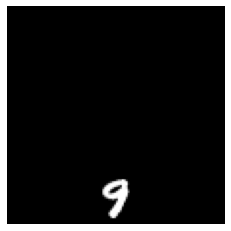

x.shape (1, 112, 112, 1)

[[4.3870658e-12 5.3980647e-09 7.3366535e-10 1.3124144e-05 2.2014456e-04
  4.7286330e-09 3.4700708e-12 2.6757616e-04 2.6006924e-07 9.9949884e-01]]
predicted_class 9
correct_class 9
int64


In [15]:
p = 8991
x = sorted_x[p]
x_org = x.copy()
print(x.shape)
plt.imshow(x.reshape(112, 112), cmap="gray")
plt.axis("off")
plt.show()
x = np.expand_dims(x, axis=0)
print("x.shape", x.shape)
# x = preprocess_input(x)
preprocessed_input = x
predictions = model.predict(preprocessed_input)
print(predictions)
predicted_class = np.argmax(predictions)
print("predicted_class", predicted_class)
print("correct_class",  sorted_y[p])
print(predicted_class.dtype)

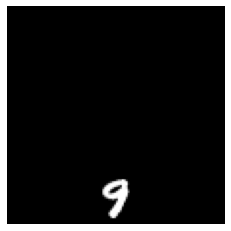

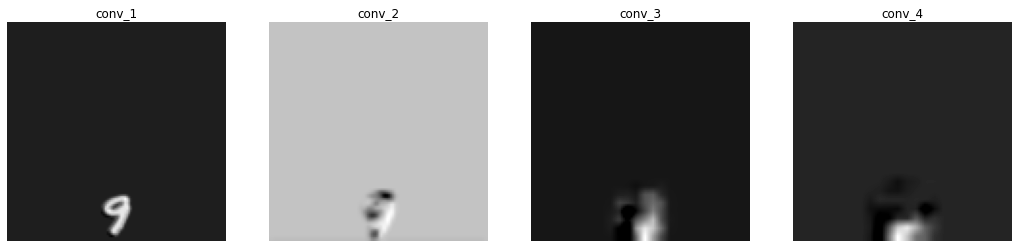

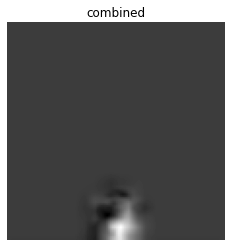

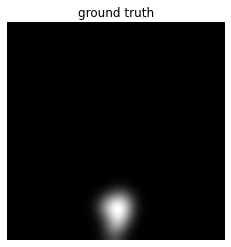

KL divergenvce
3.0238559153080047


In [16]:
plt.imshow(x_org.reshape(112, 112), cmap="gray")
plt.axis("off")
plt.show()
f, a = plt.subplots(1, 4, figsize=(18, 36))
for i in range(1, 5):
    layer_name = "conv_"+str(i)
    cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, layer_name, sparse=False)

    if i ==1:
        combined = np.zeros((heatmap.shape))
    # if i == 2:
    #   pass
    # else:
    combined += heatmap
    # cam_gray = cam.mean(axis=2)
    a[i-1].imshow(heatmap, cmap="gray")
    a[i-1].title.set_text(layer_name)
    a[i-1].axis('off')
plt.show()

combined /= np.sum(combined)
# combined = np.maximum(combined, 0)
plt.imshow(combined, cmap="gray")
plt.title("combined")
plt.axis("off")
plt.show()

x_comb_gt = scipy.ndimage.gaussian_filter(x_org.reshape(112, 112), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
plt.imshow(x_comb_gt, cmap="gray")
plt.title("ground truth")
plt.axis("off")
plt.show()

print("KL divergenvce")
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))

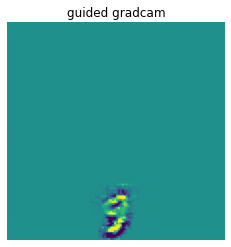

In [17]:
# cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv_4", sparse=False)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model, 'conv_4')
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

plt.imshow(deprocess_image(gradcam))
plt.title("guided gradcam")
plt.axis("off")
plt.show()

In [18]:
x_comb_gt /= np.sum(x_comb_gt)
print(np.sum(x_comb_gt))
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))
print(np.sum(combined))

1.0
3.0238559153080047
0.9999999999999999


In [19]:
kl = np.zeros(len(x_test))
show_img = False
batch_size = 50
yb4 = 0
# for img in tqdm(sorted_x):
changeLastLayer = True
results = {}
for i in tqdm(range(10)):
    # print(img.shape)
    # preprocessed_input = np.expand_dims(x_test[i], axis=0)
    preprocessed_input = sorted_x[border[i]:border[i+1]]
    # print(preprocessed_input.shape)
    # y = int(np.argmax(y_test[i]))
    y = i
    print("y", y)
    yb4 = y
    combined = batch_grad_cam(model, preprocessed_input, y,  changeLastLayer, sparse=False)
    results[i] = combined
    # show_img = True
    if show_img:
        plt.imshow(combined[0][0], cmap='gray')
        plt.show()
        plt.imshow(combined[1][0], cmap='gray')
        plt.show()
        plt.imshow(combined[2][0], cmap='gray')
        plt.show()
        plt.imshow(combined[3][0], cmap='gray')
        plt.show()
    img2test = np.sum(combined, axis=0)
    # show_img = True
    if show_img:
        print("img2test shape", img2test.shape)
        plt.imshow(img2test[0], cmap='gray')
        plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

y 0
weights shape (980, 64)
output shape (980, 26, 26, 64)
 
weights shape (980, 64)
output shape (980, 24, 24, 64)
 


 10%|█         | 1/10 [00:06<00:59,  6.62s/it]

y 1
weights shape (1135, 64)
output shape (1135, 26, 26, 64)
 
weights shape (1135, 64)
output shape (1135, 24, 24, 64)
 


 20%|██        | 2/10 [00:12<00:51,  6.40s/it]

y 2
weights shape (1032, 64)
output shape (1032, 26, 26, 64)
 
weights shape (1032, 64)
output shape (1032, 24, 24, 64)
 


 30%|███       | 3/10 [00:16<00:40,  5.74s/it]

y 3
weights shape (1010, 64)
output shape (1010, 26, 26, 64)
 
weights shape (1010, 64)
output shape (1010, 24, 24, 64)
 


 40%|████      | 4/10 [00:20<00:31,  5.21s/it]

y 4
weights shape (982, 64)
output shape (982, 26, 26, 64)
 
weights shape (982, 64)
output shape (982, 24, 24, 64)
 


 50%|█████     | 5/10 [00:24<00:24,  4.84s/it]

y 5
weights shape (892, 64)
output shape (892, 26, 26, 64)
 
weights shape (892, 64)
output shape (892, 24, 24, 64)
 


 60%|██████    | 6/10 [00:28<00:17,  4.48s/it]

y 6
weights shape (958, 64)
output shape (958, 26, 26, 64)
 
weights shape (958, 64)
output shape (958, 24, 24, 64)
 


 70%|███████   | 7/10 [00:32<00:12,  4.26s/it]

y 7
weights shape (1028, 64)
output shape (1028, 26, 26, 64)
 
weights shape (1028, 64)
output shape (1028, 24, 24, 64)
 


 80%|████████  | 8/10 [00:37<00:09,  4.60s/it]

y 8
weights shape (974, 64)
output shape (974, 26, 26, 64)
 
weights shape (974, 64)
output shape (974, 24, 24, 64)
 


 90%|█████████ | 9/10 [00:42<00:04,  4.72s/it]

y 9
weights shape (1009, 64)
output shape (1009, 26, 26, 64)
 
weights shape (1009, 64)
output shape (1009, 24, 24, 64)
 


100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


Check the produced priority map

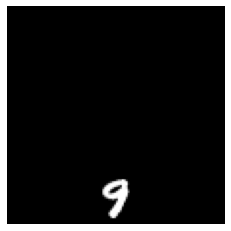

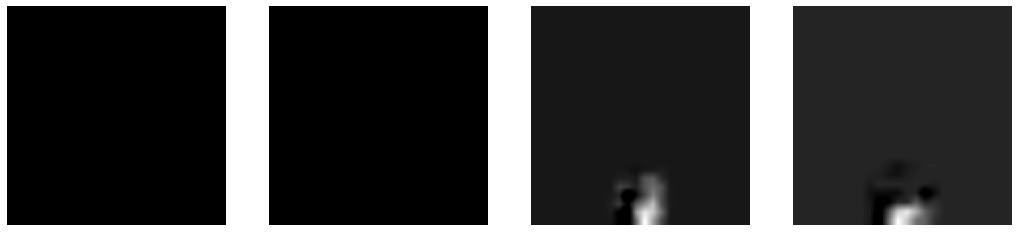

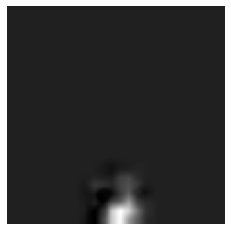

In [20]:
plt.imshow(sorted_x[border[9]].reshape(112, 112), cmap='gray')
plt.axis('off')
plt.show()

f, a = plt.subplots(1, 4, figsize=(18, 36))
a[0].imshow(combined[0][0], cmap='gray')
a[0].axis('off')
a[1].imshow(combined[0][1], cmap='gray')
a[1].axis('off')
a[2].imshow(combined[0][2], cmap='gray')
a[2].axis('off')
a[3].imshow(combined[0][3], cmap='gray')
a[3].axis('off')
plt.show()
img2test = np.sum(combined[0], axis=0)
img2test = img2test/np.sum(img2test)
plt.imshow(img2test, cmap='gray')
plt.axis('off')
plt.show()

Evaluation

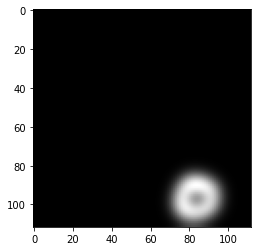

In [21]:
sorted_x_gt = np.ones((sorted_x.shape))
for i, img in enumerate(sorted_x):
  x_comb_gt = scipy.ndimage.gaussian_filter(img.reshape(112, 112), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
  x_comb_gt /= np.sum(x_comb_gt)
  sorted_x_gt[i] = np.expand_dims(x_comb_gt, axis=-1)
plt.imshow(sorted_x_gt[0].reshape(112, 112), cmap='gray')
plt.show()

In [22]:
results[0][0].shape

(4, 112, 112)

In [24]:
kls = np.zeros((len(sorted_x_gt)))
for i in range(0, 10):
  gts = sorted_x_gt[border[i]:border[i+1]] 
  pmaps = results[i]
  assert len(gts) == len(pmaps)
  temp = []
  for j in range(len(gts)):
    gt = gts[j].squeeze()
    pmap = np.sum(pmaps[j][1:], axis=0)
    # plt.imshow(pmap)
    # plt.title("pmap")
    # plt.axis("off")
    # plt.show()
    pmap /= np.sum(pmap)
    kl = stats.entropy(gt.flatten(), pmap.flatten())
    if kl == np.inf:
      continue
    temp.append(kl)
    kls[border[i]+j] = kl
  print(i, "mean kl", np.mean(temp))
print("KL divergenvce")
print(kls.mean())

0 mean kl 2.0185613915672094
1 mean kl 1.7288422900617222
2 mean kl 2.485529025045545
3 mean kl 2.702854464813763
4 mean kl 1.9141085038267132
5 mean kl 2.3290388441186343
6 mean kl 2.114802712935204
7 mean kl 1.8933793495088098
8 mean kl 2.535085543410437
9 mean kl 2.4517592424193455
KL divergenvce
0.8993124973368878


In [0]:
np.sum(gt)

1.0

In [0]:
border

[0, 980, 2115, 3147, 4157, 5139, 6031, 6989, 8017, 8991, 10000]

In [0]:
x_test.shape

(10000, 112, 112, 1)